## Get Data Ready

In [139]:
!pip install alpha_vantage

In [140]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
MY_API_KEY = 'J4PS1W9LI8IL0E97'
ENDDATE = '2019-10-01'
ONEYEARDAYS = 252
outputsize = (14,12)
output_dpi = 200
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
from datetime import timedelta
import os

In [0]:
os.chdir("/content/drive/My Drive/Presentation/")

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
import os
import scipy
from scipy import optimize
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

In [0]:
ts = TimeSeries(key='MY_API_KEY', output_format='pandas')
def get_daily_close(symbol, for_cov = False):
    full_data, meta_data = ts.get_daily(symbol = symbol, outputsize='full')
    series_index = pd.Series(full_data.index)
    full_data.index = series_index.apply(lambda t: np.datetime64(t).astype(datetime).date()).values
    assert '4. close' in full_data.columns
    close = full_data['4. close']
    close.index.name = 'Date'
    close.name = symbol
    assert close.index[0] < datetime(2005,1,3).date()
    if for_cov:
        return close[datetime(2005,1,3).date() : ]
    else:
        return close[datetime(2006,1,3).date() : ]

In [0]:
SPY = get_daily_close('SPY')
TLT = get_daily_close('TLT')
GLD = get_daily_close('GLD')
assert len(SPY) == len(TLT)
assert len(TLT) == len(GLD)
## of use pd.concat(, axis = 1)
m1 = pd.merge(left = SPY, left_index = True, right = TLT, right_index=True, how = 'inner')
dataall = pd.merge(left = m1, left_index = True, right = GLD, right_index=True, how = 'inner')

## Take a glance at the data

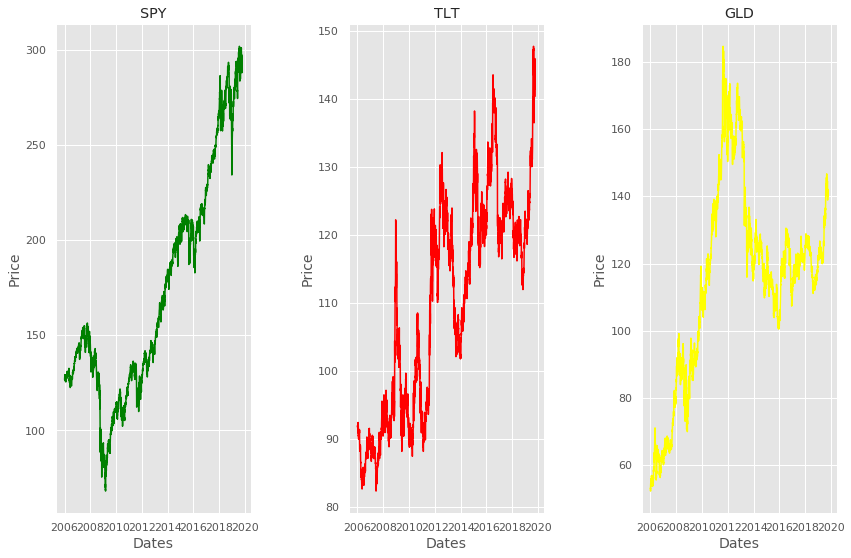

In [146]:
fig1 =plt.figure(figsize=(14,9))
plt.subplots_adjust(hspace=.5,wspace=.5) # it adds space in between plots
plt.subplot(131)
ax = plt.gca()
ax.plot(SPY, color = 'green')
ax.set_xlabel('Dates',fontsize=14)
ax.set_ylabel('Price',fontsize =14)
ax.set_title('SPY')

plt.subplot(132)
ax = plt.gca()
ax.plot(TLT, color = 'red')
ax.set_xlabel('Dates',fontsize =14)
ax.set_ylabel('Price',fontsize =14)
ax.set_title('TLT')

plt.subplot(133)
ax = plt.gca()
ax.plot(GLD, color ='yellow')
ax.set_xlabel('Dates',fontsize =14)
ax.set_ylabel('Price',fontsize =14)
ax.set_title('GLD')

plt.show();
# fig1.savefig('prices.png',dpi=400)

Each assets has a different initial value which makes difficult to compare the relative performance of each asset versus the rest of them.

Let us normalize the data to compare if you would have invested one dollar at the beginning of the observation period, how much money you would have today.

$[\frac{P_{T}^{1}}{P_{0}^{1}},\frac{P_{T}^{2}}{P_{0}^{2}},\frac{P_{T}^{3}}{P_{0}^{3}}]$

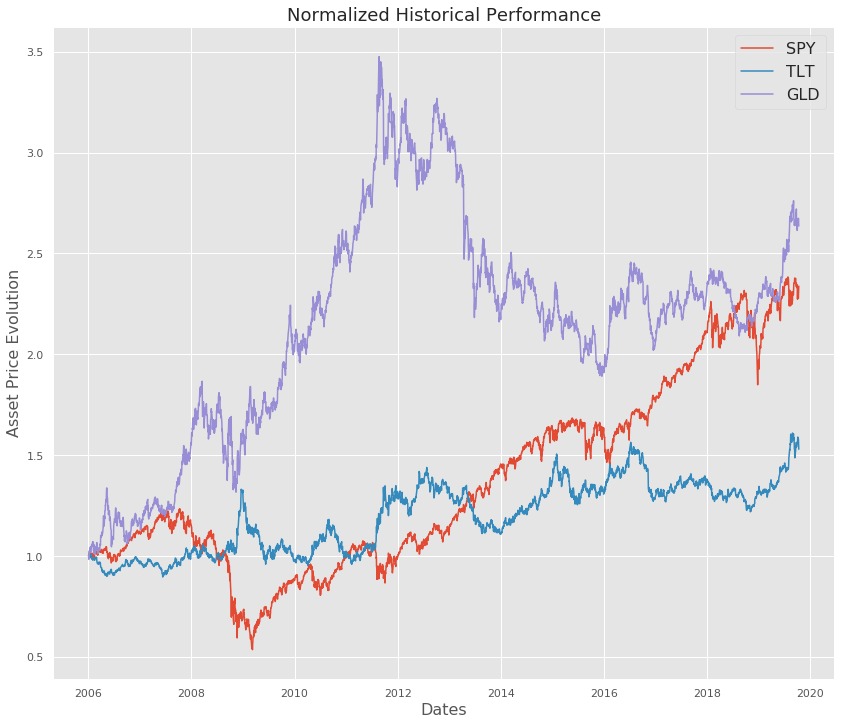

In [191]:
normalized_series = (dataall/dataall.iloc[0])
fig2 =plt.figure(figsize=outputsize)
plt.plot(normalized_series)
title_text_obj = plt.title("Normalized Historical Performance", fontsize = 18)
xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Asset Price Evolution', fontsize = 16)
plt.legend(('SPY','TLT','GLD'),fontsize = 16,loc = 'best')
plt.show()
fig2.savefig('norm_prices.png',dpi=output_dpi)

In [0]:
## Calculating return series
returns = dataall.pct_change()
returns.dropna(inplace = True)
## Daily price changing ratio
returns_mul_factor = returns + 1

spy_ret = returns['SPY']
tlt_ret = returns['TLT']
gld_ret = returns['GLD']
day_counts = len(spy_ret)
calendar = returns.index.values

## Days and calenar
day_counts = len(spy_ret)
calendar = returns.index.values

### Historical Correlation

In [149]:
np.round(returns.corr(),2)

,SPY,TLT,GLD
SPY,1.00,-0.42,0.02
TLT,-0.42,1.00,0.13
GLD,0.02,0.13,1.00


### Underlying Performance Analysis

In [189]:
stats = pd.DataFrame()
stats['Annualized Returns(%)'] = np.round(returns.mean() * ONEYEARDAYS *100,2)
stats['Annualized Volatility(%)'] = np.round(returns.std() * np.sqrt(ONEYEARDAYS)*100,2)
stats['Sharpe Ratio'] = np.round(stats['Annualized Returns(%)'] /stats['Annualized Volatility(%)'],2)
# print('Assets Classes Annualized Statistics - full observation period')
stats.style.bar(color=['red','green'], align='zero')

,Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio
SPY,7.97,18.93,0.42
TLT,4.06,13.89,0.29
GLD,8.78,18.61,0.47


In [0]:
# import imgkit
# html_str = stats.style.bar(color=['red','green'], align='zero').render()
# imgkit.from_string(html_str,'underlyingstats.png')

  $Skewness = E\left[\left(\frac{X -\mu}{\sigma}\right)^3\right]$
  
  $Kurtosis = E\left[\left(\frac{X -\mu}{\sigma}\right)^4\right]$

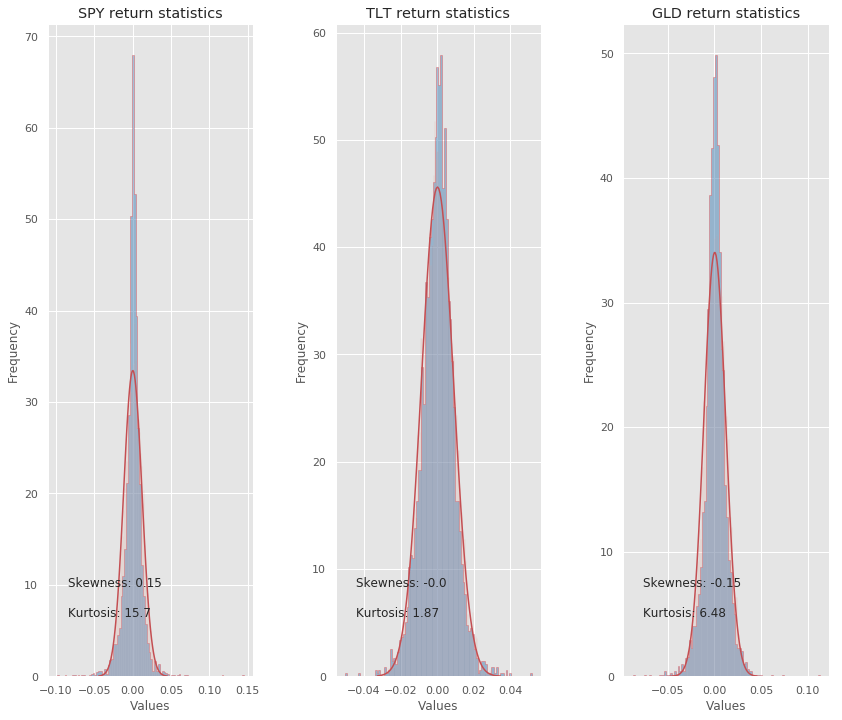

In [190]:
binsnumber = 100

fig3, ax = plt.subplots(figsize=outputsize)
plt.subplots_adjust(hspace=.4,wspace=.4) # it adds space in between plots

plt.subplot(131)
ax = plt.gca()

ax.hist(returns['SPY'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = returns['SPY'].std(),returns['SPY'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns['SPY'].skew(),2),
                                                  round(returns['SPY'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('SPY return statistics')


#####################
plt.subplot(132)
ax = plt.gca()

ax.hist(returns['TLT'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = returns['TLT'].std(),returns['TLT'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns['TLT'].skew(),2),
                                                  round(returns['TLT'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('TLT return statistics')


#####################
plt.subplot(133)
ax = plt.gca()

ax.hist(returns['GLD'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = returns['GLD'].std(),returns['GLD'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns['GLD'].skew(),2),
                                                  round(returns['GLD'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('GLD return statistics')

plt.show();
fig3.savefig('histos.png',dpi=output_dpi)

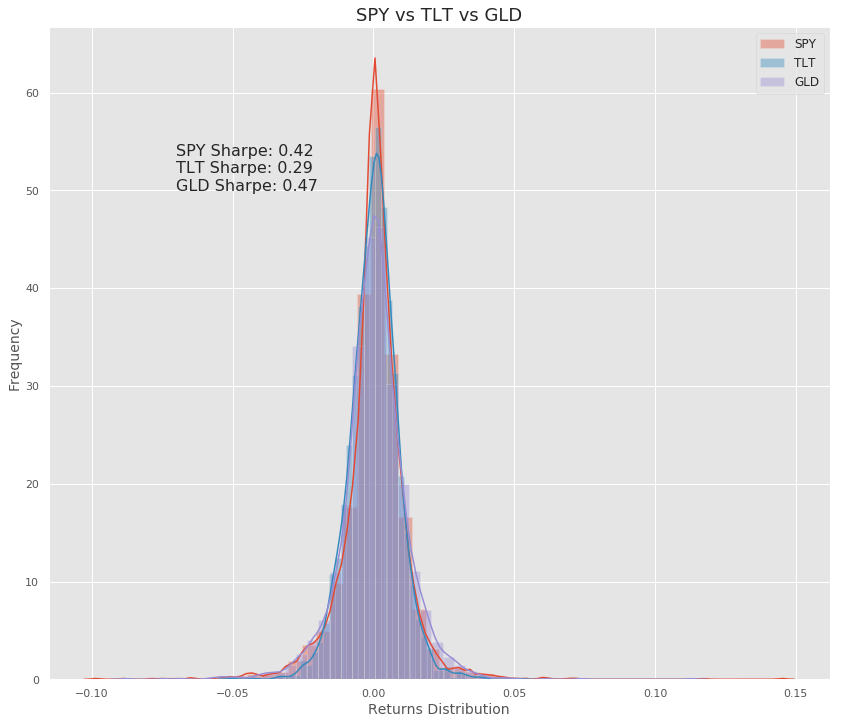

In [192]:
fig4 = plt.figure(figsize=outputsize)
sns.distplot(returns['SPY'])
sns.distplot(returns['TLT'])
sns.distplot(returns['GLD'])
plt.legend(('SPY','TLT','GLD'),fontsize = 12)

# anotate an important value
plt.annotate(' \nSPY Sharpe: {}\nTLT Sharpe: {} \nGLD Sharpe: {}'.format(round(stats.loc['SPY','Sharpe Ratio'],2),round(stats.loc['TLT','Sharpe Ratio'],2), round(stats.loc['GLD','Sharpe Ratio'],2)),
             xy=(-.01,40),xycoords = 'data',xytext =(-.07, 50),fontsize=16)
plt.title('SPY vs TLT vs GLD',fontsize=18)
plt.xlabel('Returns Distribution', fontsize= 14)
plt.ylabel('Frequency',fontsize=14)
plt.show();
fig4.savefig('histos_all.png',dpi=output_dpi)

## Risk Parity:
$$ r_p = \sum_{i}^{N}x_{i}r_{i}, \sigma_{p} = \sqrt{\sum_{i}^{N}\sum_{j}^{N}x_{i}x_{j}\sigma_{ij}}$$

Marginal Risk Contribution (MRC):
$$MRC_{i} = \frac{\partial{\sigma_p}}{\partial{x_i}} = \sum_{i}^{N} \frac{x_i\sigma_{ij}}{\sigma_p} = cov(r_i, r_p)/\sigma_p$$

Marginal Risk Contribution shows the increase of portfolio risk when we increase a unit of the asset $x_i$, so we can get the Total Risk Contribution (TRC)

$$TRC_i = x_i \frac{\partial{\sigma_p}}{\partial{x_i}} = \sum_{i}^{N} x_i x_j \sigma_{ij}/ \sigma_p  = x_i cov(r_i, r_p)/ \sigma_p$$

If we sum up all the Total Risk Contribution of asset $x_i$ we got :
$$ \sum_{i}^{N} TRC_i = \sum_{i}^{N} x_i cov(r_i, r_p) = \sigma_p$$

If we need to allocate risk equally, we need to make sure 
$$ x_i \frac{\partial{\sigma_p}}{\partial{\sigma_i}} = x_j \frac{\partial{\sigma_p}}{\partial{\sigma_j}} = \lambda, \forall i,j$$

In realistic numerical optimization, we can solve like this:
$$ min \sum_{i}^{N}\sum_{j}^{N}(TRC_i - TRC_j)^2$$
$$ s.t. \sum_{i}^{N} x_i = 1$$

In [0]:
def equal_risk(weight, cov):
    TRC1 = weight[0]**2 * cov.iloc[0, 0] + \
        weight[0]*weight[1] * cov.iloc[1,0] + \
        weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[2,0]
        
    TRC2 = weight[0]*weight[1] * cov.iloc[0,1] + \
        weight[1]**2 * cov.iloc[1,1] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[2,1]
        
    TRC3 = weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[0,2] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[1,2] + \
        (1 - weight[0] - weight[1])**2 * cov.iloc[2,2]
        
    return np.square(TRC1 - TRC2)+ np.square(TRC2 - TRC3) + np.square(TRC1 - TRC3)

def TRC(weight,cov):
    """
    Total Risk Contribution
    """
    TRC1 = weight[0]**2 * cov.iloc[0, 0] + \
        weight[0]*weight[1] * cov.iloc[1,0] + \
        weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[2,0]
        
    TRC2 = weight[0]*weight[1] * cov.iloc[0,1] + \
        weight[1]**2 * cov.iloc[1,1] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[2,1]
        
    TRC3 = weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[0,2] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[1,2] + \
        (1 - weight[0] - weight[1])**2 * cov.iloc[2,2]
    
    Var_Portfolio = np.dot(np.dot(weight, cov), weight.T)
    
    return np.array([TRC1, TRC2, TRC3])/Var_Portfolio
    
def weight_calculation(cov_df):
    ans = minimize(equal_risk, [0.1, 0.1], (cov_df), method='L-BFGS-B',  bounds=((0,1), (0,1)))
    result = []
    result.extend(list(ans.x))
    result.append(1- ans.x.sum())
    return np.array(result)

In [0]:
## For calculating covariance, need more historical data
cSPY = get_daily_close('SPY', for_cov=True)
cTLT = get_daily_close('TLT', for_cov=True)
cGLD = get_daily_close('GLD', for_cov=True)
assert len(cSPY) == len(cTLT)
assert len(cTLT) == len(cGLD)
left = pd.merge(left = cSPY, left_index = True, right = cTLT, right_index=True, how = 'inner')
dataall_c = pd.merge(left = left, left_index = True, right = cGLD, right_index=True, how = 'inner')
returns_c = dataall_c.pct_change()
returns_c.dropna(inplace = True)

In [156]:
allocation = pd.DataFrame(data =[[.3333,.3333],[.3333,.3333],[.3333,.3333]],
                          index=['SPY','TLT','GLD'],
                         columns =['Risk','Capital'])
allocation

,Risk,Capital
SPY,0.3333,0.3333
TLT,0.3333,0.3333
GLD,0.3333,0.3333


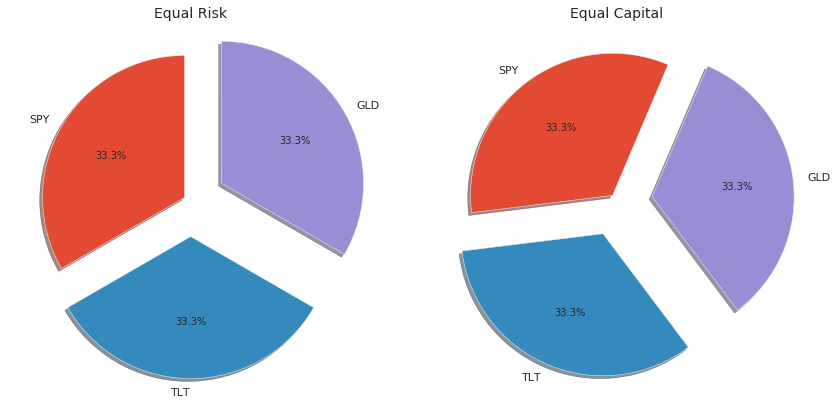

In [193]:
fig5 =plt.figure(figsize=outputsize)
ax = plt.axes([0.1, 0.1, 0.8, 0.8])
explode = [.05,.25,.25]

labels = ['SPY','TLT','GLD']

plt.subplot(121)
plt.pie(allocation['Risk'], explode = explode, labels= labels,
       autopct= '%1.1f%%', startangle = 90,shadow=True)
plt.title('Equal Risk',fontsize =14)

plt.subplot(122)
plt.pie(allocation['Capital'], explode = explode, labels= labels,
       autopct= '%1.1f%%', startangle = 67, shadow= True)
plt.title('Equal Capital',fontsize =14)

plt.show();
fig5.savefig('pies.png',dpi=output_dpi)

## Back-test function

In [0]:
def Backtest(cov_frequency, rebalance_frequency, method, get_records = False, FEE = 0.0005):
    
    ## Calculating covariance matrix

    cov_series = returns_c.rolling(window = cov_frequency).cov() * ONEYEARDAYS
  
  
    if method == "Equal Risk":
        
        rebalance_cov = [] ## [{date : covariance},...]
        rebalance_times = day_counts//rebalance_frequency

        for i in range(1, rebalance_times + 1):
            ## Indexing the covariance matrix, in pair of (date, covariance matrix)
            date = calendar[rebalance_frequency * i  - 1]
            rebalance_cov.append((date,cov_series.loc[date]))   
        
        ## Get rebalancing date and weight
        rebalance_pair = {} ## {date : weight}
        for i in range(len(rebalance_cov)):
            res = weight_calculation(rebalance_cov[i][1])
            rebalance_pair.update({rebalance_cov[i][0] : res})

        rebalance_pair = pd.Series(rebalance_pair)
        rebalance_date = rebalance_pair.index.values
        rebalance_weight = rebalance_pair.values
        new_calendar = calendar[calendar > rebalance_date[0]]
        
        cov_pair = {}  ## {date : covariance}
        for date in new_calendar:
            cov_pair.update({date : cov_series.loc[date]})
     
        ## backtest equal risk result
        backtest_result = {}
        risk_contribution = pd.DataFrame()
        backtest_weight = pd.DataFrame()

        current_asset = rebalance_weight[0] * 1000
        current_weight = rebalance_weight[0]
        backtest_weight.update({rebalance_date[0] : current_weight})
        current_cov = cov_pair.get(rebalance_date[0])
        ## Invest 1000 unit at the first day
        backtest_result.update({rebalance_date[0] : 1000})
            
        for date in new_calendar:

            if date not in rebalance_date:
                ## at the end of day, market closed (we use close level to calculate return)
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                current_weight = current_asset / current_level
                backtest_weight[date] = current_weight
                backtest_result.update({date: current_level})
                current_cov = cov_pair.get(date)
                risk_contribution[date] = TRC(current_weight, current_cov)
                
            elif date in rebalance_date:
                ## at rebalance day, we hold till market close, get rolling covariance matrix, then rebalance
                ## Forward bias: rebalance should be done before market close, 
                ## while we calculate our rebalance weight using the close level of that day. 
                ## If market has no big move near close it's OK.
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                ## Get new rebalance weight, deduct general fee
                previous_asset = current_asset
                current_asset = rebalance_pair.get(date) * current_level
                current_asset -= np.abs(previous_asset - current_asset) * FEE
                current_level -= (np.abs(previous_asset - current_asset) * FEE).sum() 
                backtest_result.update({date: current_level})
                ## Calculate Total Risk Contribution
                current_weight = rebalance_pair.get(date)
                backtest_weight[date] = current_weight
                current_cov = cov_pair.get(date) ## Covariance based on close of the rebalance day
                risk_contribution[date] = TRC(current_weight, current_cov)
                
        backtest_result = pd.Series(backtest_result) 
        risk_contribution = risk_contribution.T
        risk_contribution.columns = ['SPY','TLT','GLD']
        backtest_weight = backtest_weight.T
        backtest_weight.columns = ['SPY','TLT','GLD']
        backtest_weight.index.name = 'Date'
        backtest_result.index.name = 'Date'
        risk_contribution.index.name = 'Date'
        
        if get_records == True:
            return backtest_result, risk_contribution, backtest_weight
        else:
            return backtest_result
        
    elif method == "Equal Capital":
        ## Get rebalancing date and weight
        rebalance_times = day_counts//rebalance_frequency
        rebalance_date = []
        
        for i in range(1, rebalance_times + 1):  
            date = calendar[rebalance_frequency * i  - 1]
            rebalance_date.append(date)
        
        new_calendar = calendar[calendar > rebalance_date[0]]
        
        cov_pair = {}  ## {date : covariance}
        for date in new_calendar:
            cov_pair.update({date : cov_series.loc[date]})
            
        ## backtest equal capital result
        backtest_result = {}
        risk_contribution = pd.DataFrame()
        backtest_weight = pd.DataFrame()
        
        equal_capital_weight = np.array([1,1,1])/3
        current_asset = equal_capital_weight * 1000
        backtest_weight.update({rebalance_date[0] : equal_capital_weight})
        current_cov = cov_pair.get(rebalance_date[0])
        ## Invest 1000 unit at the first day
        backtest_result.update({rebalance_date[0] : 1000})

        for date in new_calendar:

            if date not in rebalance_date:
                ## at the end of day, market closed (we use close level to calculate return)
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                current_weight = current_asset / current_level
                backtest_weight[date] = current_weight
                backtest_result.update({date: current_level})
                current_cov = cov_pair.get(date)
                risk_contribution[date] =  TRC(current_weight, current_cov)
                
            elif date in rebalance_date:
                 ## at rebalance day, we hold till market close, get rolling covariance matrix, then rebalance with equal capital
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                ## Get new rebalance weight
                previous_asset = current_asset
                current_asset = equal_capital_weight * current_level
                current_asset -= np.abs(previous_asset - current_asset) * FEE
                current_level -= (np.abs(previous_asset - current_asset) * FEE).sum()
                current_weight = equal_capital_weight
                backtest_result.update({date: current_level})
                backtest_weight[date] = equal_capital_weight
                ## Calculate Total Risk Contribution
                current_cov = cov_pair.get(date) ## Covariance based on close of the rebalance day
                risk_contribution[date] = TRC(current_weight, current_cov)

        backtest_result = pd.Series(backtest_result)
        risk_contribution = risk_contribution.T
        risk_contribution.columns = ['SPY','TLT','GLD']
        backtest_weight = backtest_weight.T
        backtest_weight.columns = ['SPY','TLT','GLD']
        backtest_weight.index.name = 'Date'
        backtest_result.index.name = 'Date'
        risk_contribution.index.name = 'Date'
        
        if get_records == True:
            return backtest_result, risk_contribution, backtest_weight
        else:
            return backtest_result
        

## Backtest Analysis

In [0]:
def MaxDD(result, get_pair = False):
    i = np.argmax(np.maximum.accumulate(result) - result) # end of the period
    j = np.argmax(result[:i]) # start of period
    if get_pair == False:
        return np.round((result[i] - result[j])/result[j] * 100,2)
    else:
        return (j,i)
    
def performance_analysis(backtest_result):
    strategy_return = backtest_result.pct_change().dropna()
    strategy_stats = pd.DataFrame()
    ##Compound Annual Growth Rate
    N = len(backtest_result)/ONEYEARDAYS
    strategy_stats['CAGR(%)'] = np.round((np.power(backtest_result.iloc[-1]/backtest_result.iloc[0],1/N) - 1)*100,2)
    strategy_stats['Annualized Returns(%)'] = np.round(strategy_return.mean() * ONEYEARDAYS *100,2)
    strategy_stats['Annualized Volatility(%)'] = np.round(strategy_return.std() * np.sqrt(ONEYEARDAYS)*100,2)
    strategy_stats['Sharpe Ratio'] = np.round(strategy_stats['Annualized Returns(%)'] /strategy_stats['Annualized Volatility(%)'],2)
    
    mdd = {}
    for colName in backtest_result.columns:
        mdd.update({colName : MaxDD(backtest_result[colName].values)})
    
    strategy_stats['MaxDD (%)'] = pd.Series(mdd) 
       
    return strategy_stats

In [0]:
backtest_result = pd.DataFrame()
backtest_result['Equal Capital'] = Backtest(cov_frequency=30, rebalance_frequency=30,
                                            method = "Equal Capital",get_records=False)
backtest_result['Equal Risk'] = Backtest(cov_frequency=30, rebalance_frequency=30, 
                                         method = "Equal Risk",get_records=False)
strategy_return = backtest_result.pct_change().dropna()
strategy_return;

In [161]:
all_result = pd.merge(left= backtest_result, left_index = True, right=dataall, right_index = True, how = 'inner' )
strategy_stats = performance_analysis(backtest_result=all_result)
# print('Strategy Performance Annualized Statistics - full observation period')
strategy_stats.style.bar(color=['red','green'], align='zero')

,CAGR(%),Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio,MaxDD (%)
Equal Capital,6.45,6.66,9.04,0.74,-21.37
Equal Risk,6.91,7,7.97,0.88,-9.46
SPY,6.33,7.94,18.99,0.42,-56.47
TLT,3.3,4.22,13.93,0.3,-28.46
GLD,7.27,8.74,18.55,0.47,-45.56


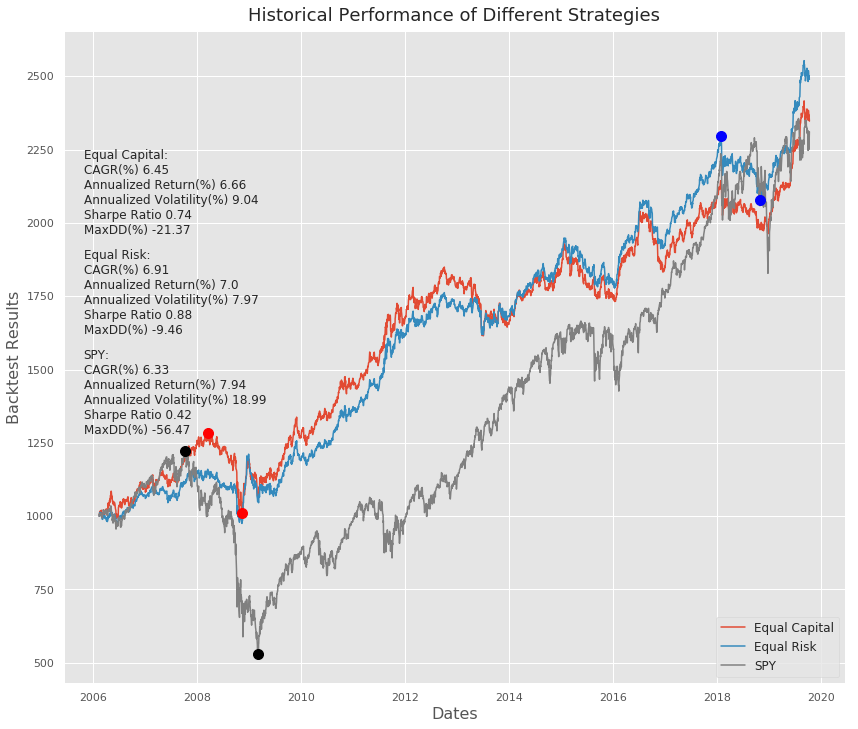

In [194]:
fig6 =plt.figure(figsize=outputsize)
ax = plt.gca()

ax.plot(all_result[['Equal Capital', 'Equal Risk']])
ax.plot(all_result[['SPY']]/all_result[['SPY']].iloc[0] * 1000, color = 'grey', linestyle="-" )

eci,ecj = MaxDD(all_result['Equal Capital'], get_pair = True)
plt.plot([eci, ecj], [all_result['Equal Capital'].loc[eci], 
                      all_result['Equal Capital'].loc[ecj]], 'o', color='Red', markersize=10)


eri,erj = MaxDD(all_result['Equal Risk'], get_pair = True)
plt.plot([eri, erj], [all_result['Equal Risk'].loc[eri], 
                      all_result['Equal Risk'].loc[erj]], 'o', color='blue', markersize=10)

spi,spj = MaxDD(all_result['SPY'], get_pair = True)
plt.plot([spi, spj], [all_result['SPY'].loc[spi]/all_result[['SPY']].iloc[0] * 1000, 
                      all_result['SPY'].loc[spj]/all_result[['SPY']].iloc[0] * 1000], 'o', color='black', markersize=10)

title_text_obj = plt.title("Historical Performance of Different Strategies", fontsize = 18,
                          verticalalignment = 'bottom')
current_stats = strategy_stats
xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Backtest Results', fontsize = 16)
ax.legend(('Equal Capital', 'Equal Risk','SPY'),fontsize = 12, loc='lower right')
ax.annotate('Equal Capital:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['Equal Capital'],2),
            np.round(current_stats['Annualized Returns(%)']['Equal Capital'],2),
            np.round(current_stats['Annualized Volatility(%)']['Equal Capital'],2),
            np.round(current_stats['Sharpe Ratio']['Equal Capital'],2),
            np.round(current_stats['MaxDD (%)']['Equal Capital'],2)),
            xy=(20,450),xycoords = 'axes points',fontsize=12)

ax.annotate('Equal Risk:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['Equal Risk'],2),
            np.round(current_stats['Annualized Returns(%)']['Equal Risk'],2),
            np.round(current_stats['Annualized Volatility(%)']['Equal Risk'],2),
            np.round(current_stats['Sharpe Ratio']['Equal Risk'],2),
            np.round(current_stats['MaxDD (%)']['Equal Risk'],2)),
            xy=(20,350),xycoords = 'axes points',fontsize=12)

ax.annotate('SPY:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['SPY'],2),
            np.round(current_stats['Annualized Returns(%)']['SPY'],2),
            np.round(current_stats['Annualized Volatility(%)']['SPY'],2),
            np.round(current_stats['Sharpe Ratio']['SPY'],2),
            np.round(current_stats['MaxDD (%)']['SPY'],2)),
            xy=(20,250),xycoords = 'axes points',fontsize=12)
plt.show()
fig6.savefig('backtest_compare.png',dpi=output_dpi)

In [0]:
## Compare different rebalance frequency, fix covariance computation frequency
backtest_result2 = pd.DataFrame()

backtest_result2['20 day rebalance'] = Backtest(cov_frequency= 90,  rebalance_frequency=20, 
                                                           method = "Equal Risk")
backtest_result2['30 day rebalance'] = Backtest(cov_frequency= 90, rebalance_frequency=30, 
                                                            method = "Equal Risk")
backtest_result2['60 day rebalance'] = Backtest(cov_frequency= 90,  rebalance_frequency=60,
                                                           method = "Equal Risk")

backtest_result2 = backtest_result2.fillna(1000)


In [164]:
all_result2 = pd.merge(left= backtest_result2, left_index = True, right=dataall, right_index = True, how = 'inner' )
strategy_stats2 = performance_analysis(backtest_result=all_result2)
# print('Strategy Performance Annualized Statistics - full observation period')
strategy_stats2.style.bar(color=['red','green'], align='zero')

,CAGR(%),Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio,MaxDD (%)
20 day rebalance,6.32,6.44,7.94,0.81,-9.3
30 day rebalance,6.51,6.63,7.98,0.83,-9.3
60 day rebalance,6.19,6.34,8.05,0.79,-18.06
SPY,6.3,7.91,18.98,0.42,-56.47
TLT,3.3,4.22,13.92,0.3,-28.46
GLD,6.83,8.34,18.59,0.45,-45.56


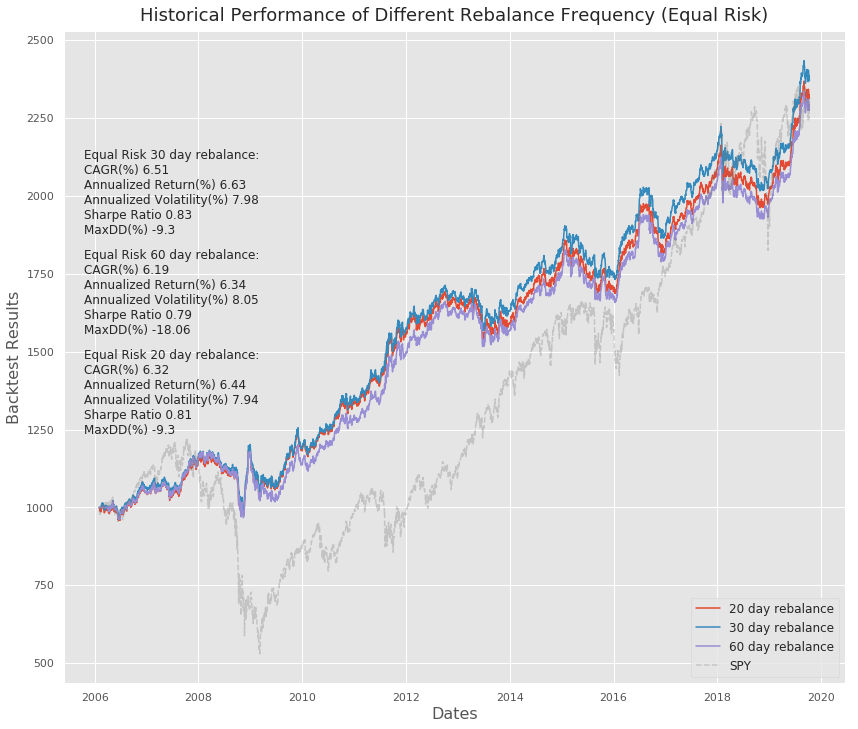

In [195]:
fig7 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(backtest_result2[['20 day rebalance', '30 day rebalance', '60 day rebalance']])
current_stats = strategy_stats2
ax.plot(all_result2[['SPY']]/all_result2[['SPY']].iloc[0] * 1000, alpha = 0.3,linestyle="--" )
title_text_obj = plt.title("Historical Performance of Different Rebalance Frequency (Equal Risk)", fontsize = 18,
                          verticalalignment = 'bottom')


xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Backtest Results', fontsize = 16)
ax.legend(('20 day rebalance', '30 day rebalance', '60 day rebalance','SPY'),fontsize = 12, loc='lower right')

ax.annotate('Equal Risk 20 day rebalance:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['20 day rebalance'],2),
            np.round(current_stats['Annualized Returns(%)']['20 day rebalance'],2),
            np.round(current_stats['Annualized Volatility(%)']['20 day rebalance'],2),
            np.round(current_stats['Sharpe Ratio']['20 day rebalance'],2),
            np.round(current_stats['MaxDD (%)']['20 day rebalance'],2)),
            xy=(20,250),xycoords = 'axes points',fontsize=12)

ax.annotate('Equal Risk 30 day rebalance:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['30 day rebalance'],2),
            np.round(current_stats['Annualized Returns(%)']['30 day rebalance'],2),
            np.round(current_stats['Annualized Volatility(%)']['30 day rebalance'],2),
            np.round(current_stats['Sharpe Ratio']['30 day rebalance'],2),
            np.round(current_stats['MaxDD (%)']['30 day rebalance'],2)),
            xy=(20,450),xycoords = 'axes points',fontsize=12)

ax.annotate('Equal Risk 60 day rebalance:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['60 day rebalance'],2),
            np.round(current_stats['Annualized Returns(%)']['60 day rebalance'],2),
            np.round(current_stats['Annualized Volatility(%)']['60 day rebalance'],2),
            np.round(current_stats['Sharpe Ratio']['60 day rebalance'],2),
            np.round(current_stats['MaxDD (%)']['60 day rebalance'],2)),
            xy=(20,350),xycoords = 'axes points',fontsize=12)



plt.show()
fig7.savefig('ERDifferentRebalanceFreq.png',dpi=output_dpi)

In [0]:
## Compare different covariance frequency, rebalance every 30 business day
backtest_result3 = pd.DataFrame()
backtest_result3['30 day covariance'] = Backtest(cov_frequency=30, rebalance_frequency=30, 
                                                             method = "Equal Risk")
backtest_result3['60 day covariance'] = Backtest(cov_frequency=60,  rebalance_frequency=30, 
                                                            method = "Equal Risk")
backtest_result3['90 day covariance'] = Backtest(cov_frequency=90,  rebalance_frequency=30, 
                                                            method = "Equal Risk")

backtest_result3 = backtest_result3.fillna(1000)


In [167]:
all_result3 = pd.merge(left= backtest_result3, left_index = True, right=dataall, right_index = True, how = 'inner' )

strategy_stats3 = performance_analysis(backtest_result=all_result3)
# print('Strategy Performance Annualized Statistics - full observation period')
strategy_stats3.style.bar(color=['red','green'], align='zero')

,CAGR(%),Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio,MaxDD (%)
30 day covariance,6.91,7,7.97,0.88,-9.46
60 day covariance,6.38,6.5,7.97,0.82,-16.8
90 day covariance,6.53,6.65,7.99,0.83,-9.3
SPY,6.33,7.94,18.99,0.42,-56.47
TLT,3.3,4.22,13.93,0.3,-28.46
GLD,7.27,8.74,18.55,0.47,-45.56


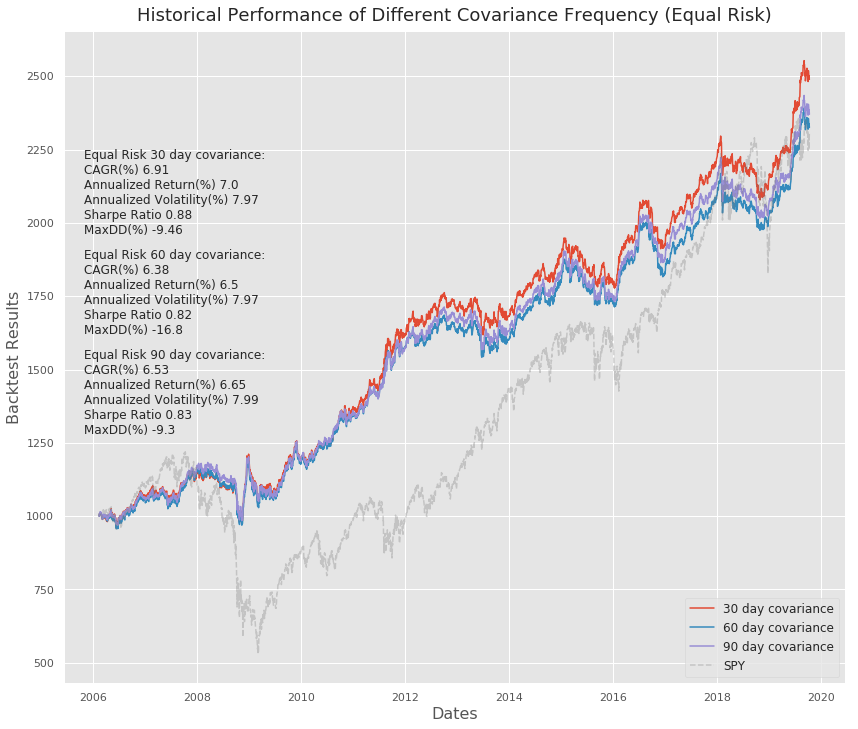

In [197]:
fig8 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(backtest_result3[['30 day covariance', '60 day covariance', '90 day covariance']])
current_stats = strategy_stats3
ax.plot(all_result3[['SPY']]/all_result3[['SPY']].iloc[0] * 1000, alpha = 0.3,linestyle="--" )
title_text_obj = plt.title("Historical Performance of Different Covariance Frequency (Equal Risk)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Backtest Results', fontsize = 16)
ax.legend(('30 day covariance', '60 day covariance', '90 day covariance','SPY'),fontsize = 12, loc='lower right')

ax.annotate('Equal Risk 30 day covariance:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['30 day covariance'],2),
            np.round(current_stats['Annualized Returns(%)']['30 day covariance'],2),
            np.round(current_stats['Annualized Volatility(%)']['30 day covariance'],2),
            np.round(current_stats['Sharpe Ratio']['30 day covariance'],2),
            np.round(current_stats['MaxDD (%)']['30 day covariance'],2)),
            xy=(20,450),xycoords = 'axes points',fontsize=12)

ax.annotate('Equal Risk 60 day covariance:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['60 day covariance'],2),
            np.round(current_stats['Annualized Returns(%)']['60 day covariance'],2),
            np.round(current_stats['Annualized Volatility(%)']['60 day covariance'],2),
            np.round(current_stats['Sharpe Ratio']['60 day covariance'],2),
            np.round(current_stats['MaxDD (%)']['60 day covariance'],2)),
            xy=(20,350),xycoords = 'axes points',fontsize=12)

ax.annotate('Equal Risk 90 day covariance:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['90 day covariance'],2),
            np.round(current_stats['Annualized Returns(%)']['90 day covariance'],2),
            np.round(current_stats['Annualized Volatility(%)']['90 day covariance'],2),
            np.round(current_stats['Sharpe Ratio']['90 day covariance'],2),
            np.round(current_stats['MaxDD (%)']['90 day covariance'],2)),
            xy=(20,250),xycoords = 'axes points',fontsize=12)


plt.show()
fig8.savefig('ERDifferentCovFreq.png',dpi=output_dpi)

In [0]:
## Set covariance calculation frequency and rebalance frequency to be the same
backtest_result4 = pd.DataFrame()
backtest_result4['30 day'] = Backtest(cov_frequency=30,  rebalance_frequency=30, 
                                                               method = "Equal Risk")
backtest_result4['60 day']  = Backtest(cov_frequency=60,  rebalance_frequency=60,
                                                               method = "Equal Risk")
backtest_result4['90 day']  = Backtest(cov_frequency=90,  rebalance_frequency=90, 
                                                               method = "Equal Risk")

backtest_result4 = backtest_result4.fillna(1000)

In [170]:
all_result4 = pd.merge(left= backtest_result4, left_index = True, right=dataall, right_index = True, how = 'inner' )

strategy_stats4 = performance_analysis(backtest_result=all_result4)
# print('Strategy Performance Annualized Statistics - full observation period')
strategy_stats4.style.bar(color=['red','green'], align='zero')

,CAGR(%),Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio,MaxDD (%)
30 day,6.91,7,7.97,0.88,-9.46
60 day,6.05,6.21,8.08,0.77,-17.93
90 day,6.79,6.9,8,0.86,-17.18
SPY,6.33,7.94,18.99,0.42,-56.47
TLT,3.3,4.22,13.93,0.3,-28.46
GLD,7.27,8.74,18.55,0.47,-45.56


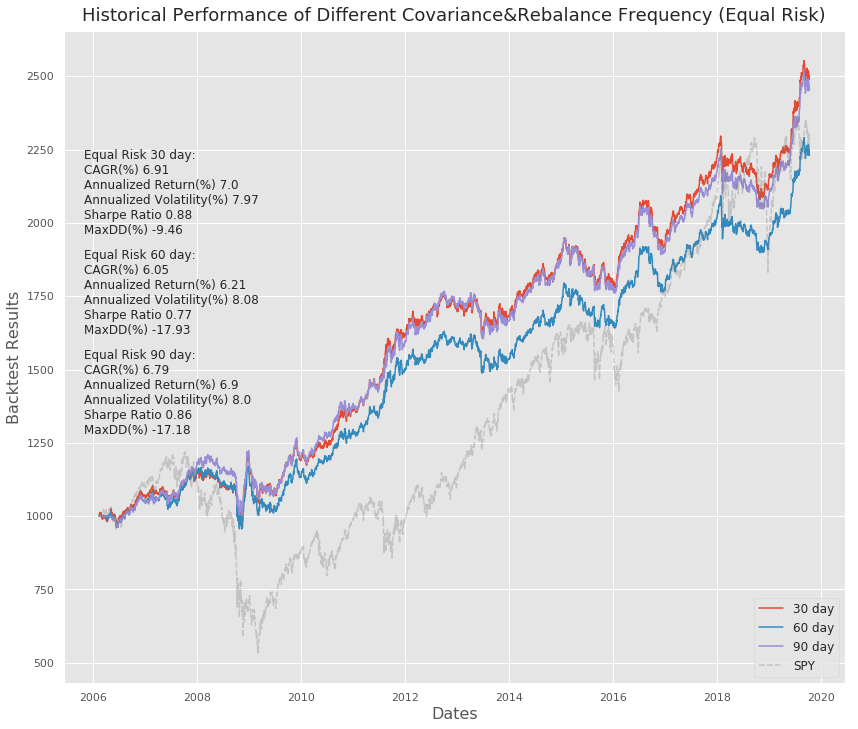

In [199]:
fig9 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(backtest_result4[['30 day', '60 day','90 day']])
current_stats = strategy_stats4
title_text_obj = plt.title("Historical Performance of Different Covariance&Rebalance Frequency (Equal Risk)", fontsize = 18,
                          verticalalignment = 'bottom')
ax.plot(all_result4[['SPY']]/all_result4[['SPY']].iloc[0] * 1000, alpha = 0.3,linestyle="--" )
xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Backtest Results', fontsize = 16)
ax.legend(('30 day', '60 day','90 day', 'SPY'),fontsize = 12, loc='lower right')

ax.annotate('Equal Risk 30 day:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['30 day'],2),
            np.round(current_stats['Annualized Returns(%)']['30 day'],2),
            np.round(current_stats['Annualized Volatility(%)']['30 day'],2),
            np.round(current_stats['Sharpe Ratio']['30 day'],2),
            np.round(current_stats['MaxDD (%)']['30 day'],2)),
            xy=(20,450),xycoords = 'axes points',fontsize=12)

ax.annotate('Equal Risk 60 day:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['60 day'],2),
            np.round(current_stats['Annualized Returns(%)']['60 day'],2),
            np.round(current_stats['Annualized Volatility(%)']['60 day'],2),
            np.round(current_stats['Sharpe Ratio']['60 day'],2),
            np.round(current_stats['MaxDD (%)']['60 day'],2)),
            xy=(20,350),xycoords = 'axes points',fontsize=12)

ax.annotate('Equal Risk 90 day:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['90 day'],2),
            np.round(current_stats['Annualized Returns(%)']['90 day'],2),
            np.round(current_stats['Annualized Volatility(%)']['90 day'],2),
            np.round(current_stats['Sharpe Ratio']['90 day'],2),
            np.round(current_stats['MaxDD (%)']['90 day'],2)),
            xy=(20,250),xycoords = 'axes points',fontsize=12)



plt.show()
fig9.savefig('ERDifferentFreq.png',dpi=output_dpi)

In [0]:
## Different frequency for equal capital 
backtest_result5 = pd.DataFrame()
backtest_result5['30 day rebalance']  = Backtest(cov_frequency=60,  rebalance_frequency=30,
                                                               method = "Equal Capital")
backtest_result5['60 day rebalance']  = Backtest(cov_frequency=60,  rebalance_frequency=60, 
                                                               method = "Equal Capital")
backtest_result5['90 day rebalance'] = Backtest(cov_frequency=60,  rebalance_frequency=90, 
                                                               method = "Equal Capital")
backtest_result5 = backtest_result5.fillna(1000)

In [174]:
all_result5 = pd.merge(left= backtest_result5, left_index = True, right=dataall, right_index = True, how = 'inner' )

strategy_stats5 = performance_analysis(backtest_result=all_result5)
# print('Strategy Performance Annualized Statistics - full observation period')
strategy_stats5.style.bar(color=['red','green'], align='zero')

,CAGR(%),Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio,MaxDD (%)
30 day rebalance,6.45,6.66,9.04,0.74,-21.37
60 day rebalance,6.16,6.38,9.02,0.71,-21.3
90 day rebalance,5.98,6.2,8.9,0.7,-21.44
SPY,6.33,7.94,18.99,0.42,-56.47
TLT,3.3,4.22,13.93,0.3,-28.46
GLD,7.27,8.74,18.55,0.47,-45.56


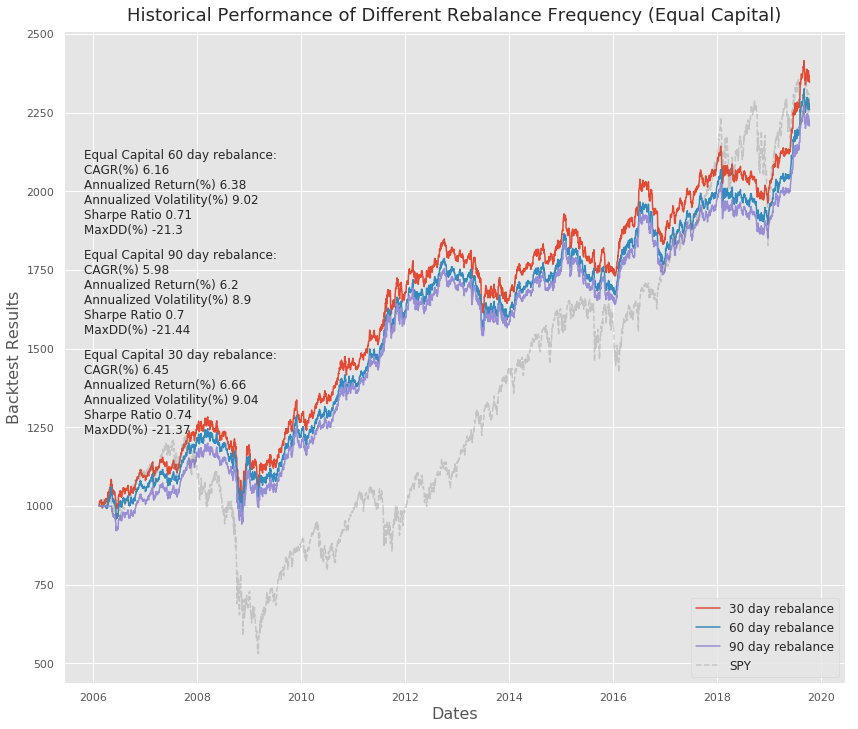

In [201]:
fig10 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(backtest_result5[['30 day rebalance','60 day rebalance', '90 day rebalance']])
current_stats = strategy_stats5
title_text_obj = plt.title("Historical Performance of Different Rebalance Frequency (Equal Capital)", fontsize = 18,
                          verticalalignment = 'bottom')
ax.plot(all_result5[['SPY']]/all_result5[['SPY']].iloc[0] * 1000, alpha = 0.3,linestyle="--" )
xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Backtest Results', fontsize = 16)
ax.legend(('30 day rebalance', '60 day rebalance', '90 day rebalance', 'SPY'),fontsize = 12, loc='lower right')


ax.annotate('Equal Capital 30 day rebalance:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['30 day rebalance'],2),
            np.round(current_stats['Annualized Returns(%)']['30 day rebalance'],2),
            np.round(current_stats['Annualized Volatility(%)']['30 day rebalance'],2),
            np.round(current_stats['Sharpe Ratio']['30 day rebalance'],2),
            np.round(current_stats['MaxDD (%)']['30 day rebalance'],2)),
            xy=(20,250),xycoords = 'axes points',fontsize=12)


ax.annotate('Equal Capital 60 day rebalance:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['60 day rebalance'],2),
            np.round(current_stats['Annualized Returns(%)']['60 day rebalance'],2),
            np.round(current_stats['Annualized Volatility(%)']['60 day rebalance'],2),
            np.round(current_stats['Sharpe Ratio']['60 day rebalance'],2),
            np.round(current_stats['MaxDD (%)']['60 day rebalance'],2)),
            xy=(20,450),xycoords = 'axes points',fontsize=12)

ax.annotate('Equal Capital 90 day rebalance:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['90 day rebalance'],2),
            np.round(current_stats['Annualized Returns(%)']['90 day rebalance'],2),
            np.round(current_stats['Annualized Volatility(%)']['90 day rebalance'],2),
            np.round(current_stats['Sharpe Ratio']['90 day rebalance'],2),
            np.round(current_stats['MaxDD (%)']['90 day rebalance'],2)),
            xy=(20,350),xycoords = 'axes points',fontsize=12)

plt.show()
fig10.savefig('ECDifferentRebalanceFreq.png',dpi=output_dpi)

In [0]:
backtest_level,risk_contribution, backtest_weight = Backtest(cov_frequency=60, rebalance_frequency=30, 
                                         method = "Equal Risk",get_records=True)

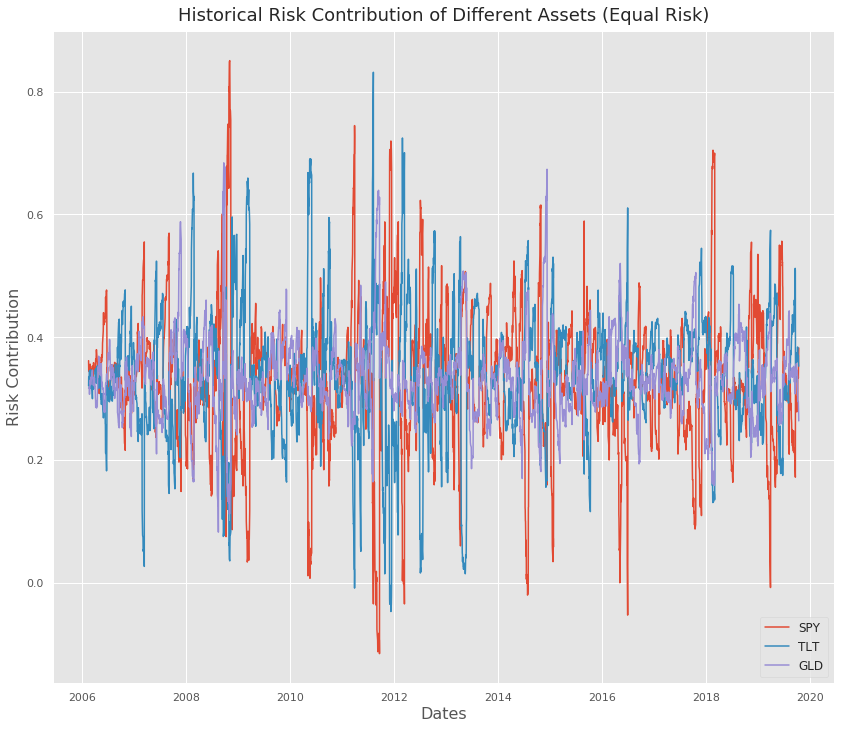

In [202]:
fig11 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(risk_contribution)

title_text_obj = plt.title("Historical Risk Contribution of Different Assets (Equal Risk)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Risk Contribution', fontsize = 16)
ax.legend(('SPY', 'TLT', 'GLD'),fontsize = 12, loc='lower right')


plt.show()
fig11.savefig('ERRiskContribution.png',dpi=output_dpi)

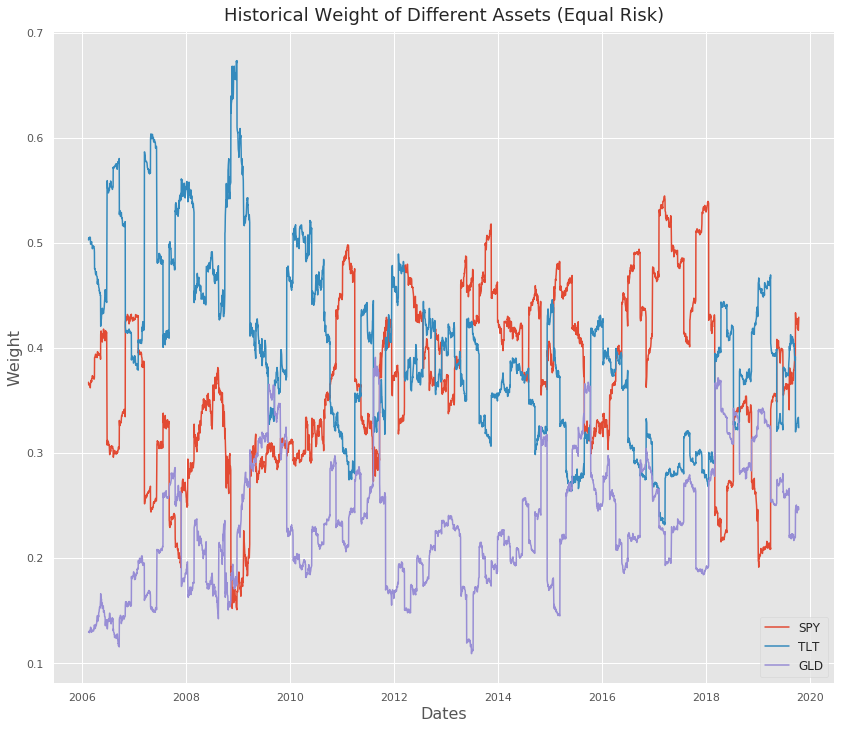

In [203]:
fig12 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(backtest_weight)

title_text_obj = plt.title("Historical Weight of Different Assets (Equal Risk)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Weight', fontsize = 16)
ax.legend(('SPY', 'TLT', 'GLD'),fontsize = 12, loc='lower right')


plt.show()
fig12.savefig('ERWeight.png',dpi=output_dpi)

In [0]:
backtest_level2,risk_contribution2, backtest_weight2 = Backtest(cov_frequency=60, rebalance_frequency=1, 
                                         method = "Equal Capital",get_records=True)

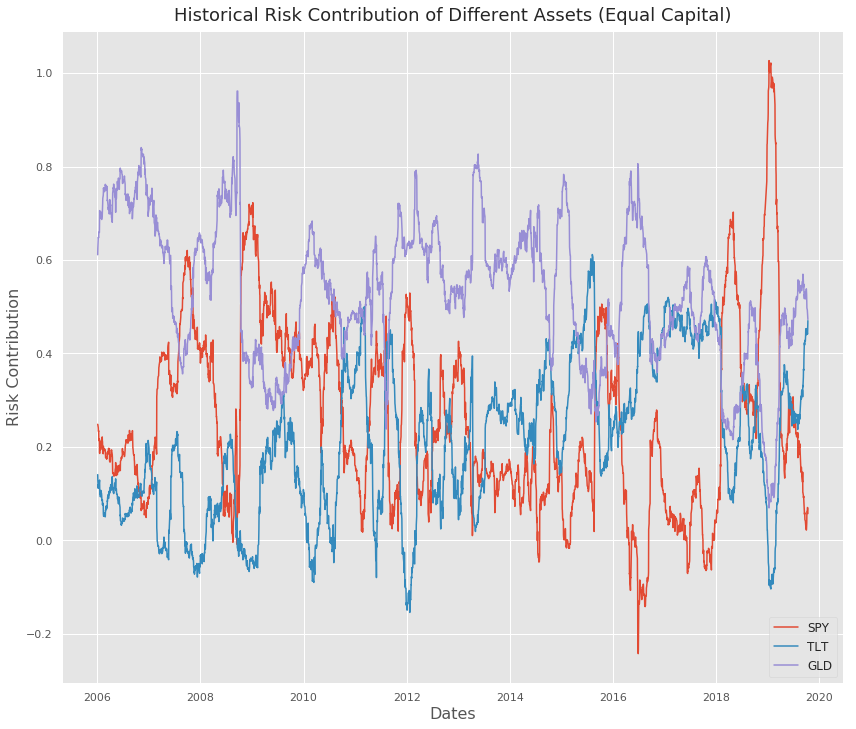

In [206]:
fig13 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(risk_contribution2)

title_text_obj = plt.title("Historical Risk Contribution of Different Assets (Equal Capital)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Risk Contribution', fontsize = 16)
ax.legend(('SPY', 'TLT', 'GLD'),fontsize = 12, loc='lower right')


plt.show()
fig13.savefig('ECRiskContribution.png',dpi=output_dpi)

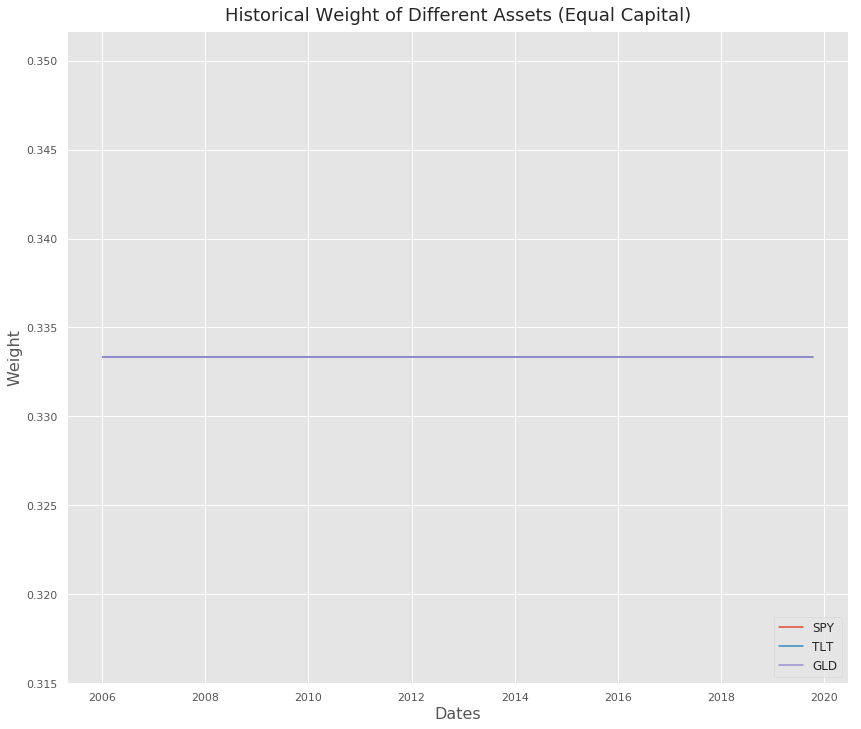

In [205]:
fig14 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(backtest_weight2)

title_text_obj = plt.title("Historical Weight of Different Assets (Equal Capital)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Weight', fontsize = 16)
ax.legend(('SPY', 'TLT', 'GLD'),fontsize = 12, loc='lower right')


plt.show()
fig14.savefig('ECWeight.png',dpi=output_dpi)

In [0]:
backtest_level3, risk_contribution3, backtest_weight3 = Backtest(cov_frequency=60, rebalance_frequency=30, 
                                         method = "Equal Capital",get_records=True)

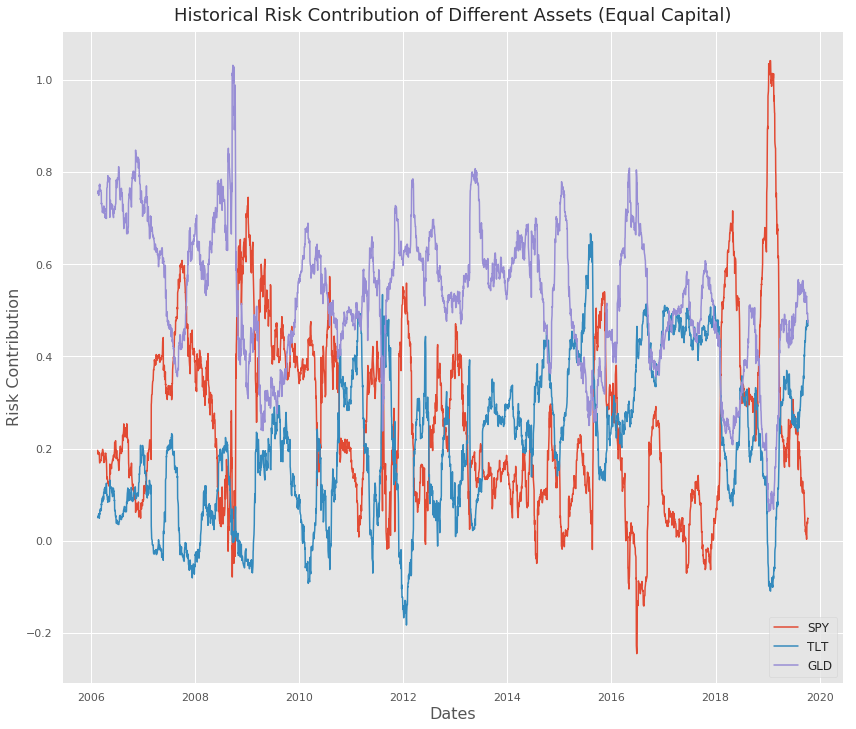

In [207]:
fig15 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(risk_contribution3)

title_text_obj = plt.title("Historical Risk Contribution of Different Assets (Equal Capital)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Risk Contribution', fontsize = 16)
ax.legend(('SPY', 'TLT', 'GLD'),fontsize = 12, loc='lower right')


plt.show()
fig15.savefig('ECRiskContribution2.png',dpi=output_dpi)

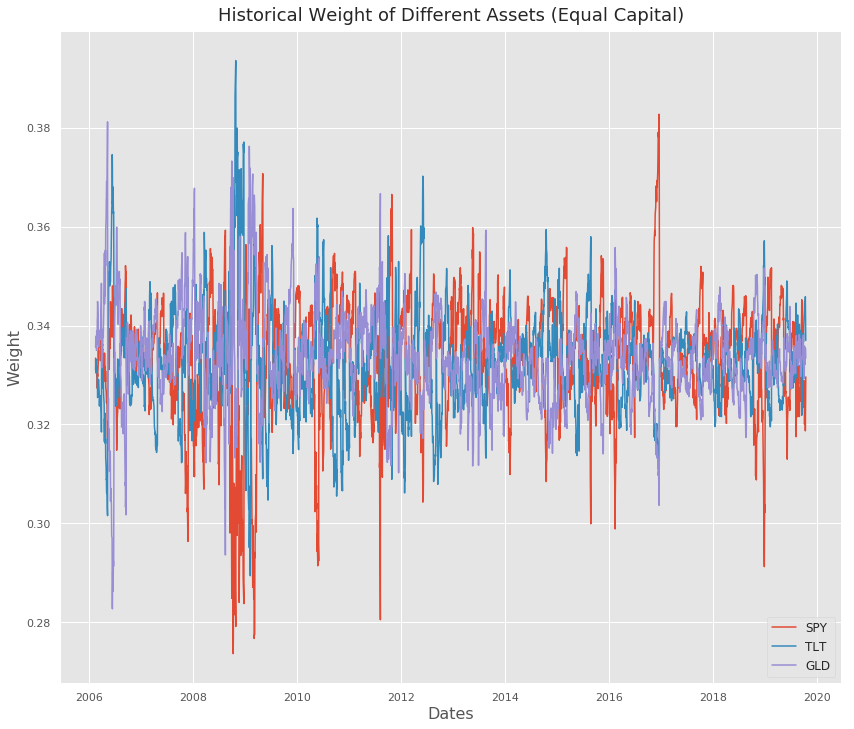

In [208]:
fig16 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(backtest_weight3)

title_text_obj = plt.title("Historical Weight of Different Assets (Equal Capital)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Weight', fontsize = 16)
ax.legend(('SPY', 'TLT', 'GLD'),fontsize = 12, loc='lower right')


plt.show()
fig16.savefig('ECWeight2.png',dpi=output_dpi)

In [0]:
backtest_level4, risk_contribution4, backtest_weight4 = Backtest(cov_frequency=60, rebalance_frequency=1, 
                                         method = "Equal Risk",get_records=True)

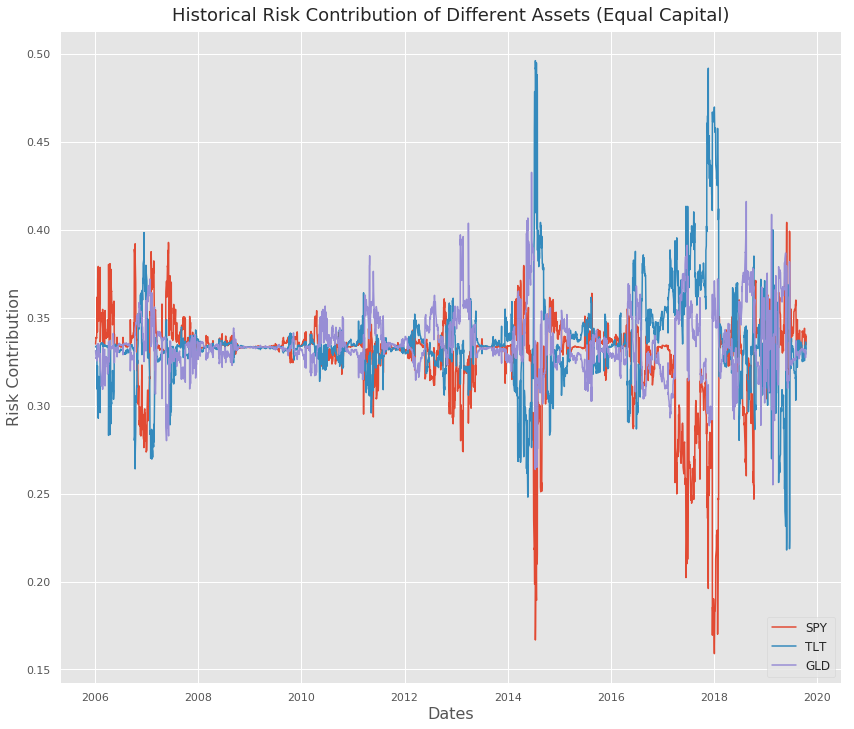

In [209]:
fig17 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(risk_contribution4)

title_text_obj = plt.title("Historical Risk Contribution of Different Assets (Equal Capital)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Risk Contribution', fontsize = 16)
ax.legend(('SPY', 'TLT', 'GLD'),fontsize = 12, loc='lower right')


plt.show()
fig17.savefig('ERRiskContribution2.png',dpi=output_dpi)

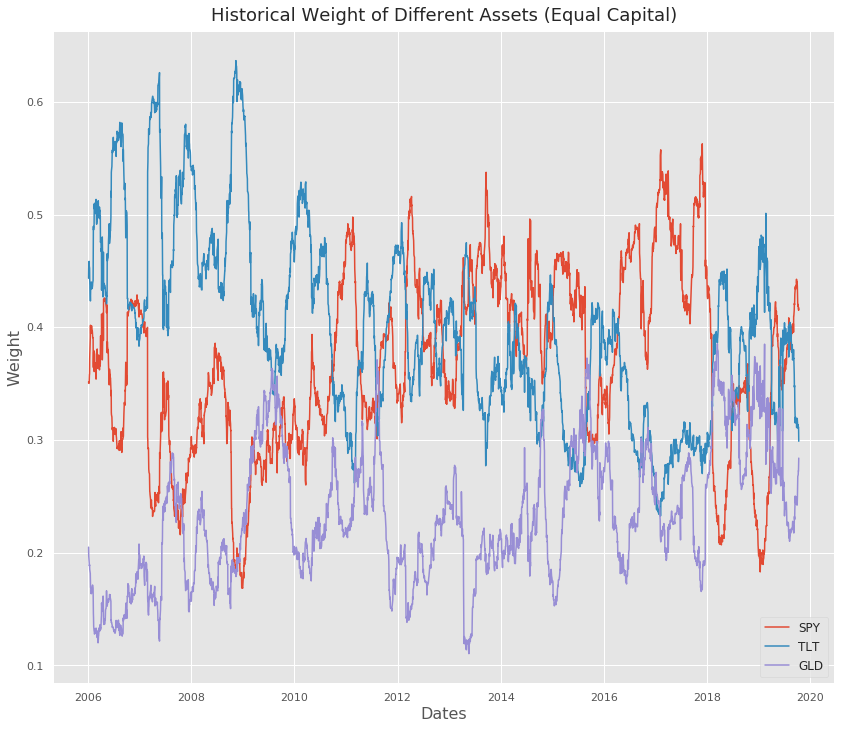

In [210]:
fig18 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(backtest_weight4)

title_text_obj = plt.title("Historical Weight of Different Assets (Equal Capital)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Weight', fontsize = 16)
ax.legend(('SPY', 'TLT', 'GLD'),fontsize = 12, loc='lower right')


plt.show()
fig18.savefig('ERWeight2.png',dpi=output_dpi)